In [81]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : Symmetric Convolution


TensorShape([50, 50])

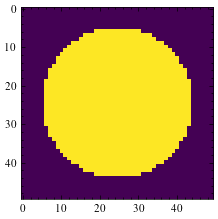

In [82]:
'''img = np.zeros((45, 45))
center_coordinates = (img.shape[0]//2, img.shape[1]//2) 
img = cv2.circle(img, center_coordinates, 20, (255,255,255), -1) 
plt.imshow(img)'''


N = 50
#img =  tf.image.rot90(tf.random.uniform(shape=(50,50,1), minval=0., maxval=1.), k=1) #
#img = tf.image.pad_to_bounding_box(img, 25//2,25//2,N+25, N+25)[...,0]

img =  tf.expand_dims(cv2.imread('input4.png', 0)/255. , axis=-1)
H, W, C = img.shape  # Get image dimensions
offset_height = (H - N) // 2
offset_width = (W - N) // 2
img = tf.image.crop_to_bounding_box(img, offset_height, offset_width, N, N)[...,0]
plt.imshow(img)
img.shape


(50, 50)


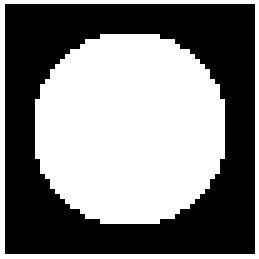

In [83]:
#var = 2/(128*9)

fig,ax = plt.subplots(1)

ax.imshow(img, cmap='gray')

#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("input.png",bbox_inches='tight',   pad_inches = 0)


In [84]:
img  = np.zeros((50, 50)) # np.random.uniform(low=0, high=1, size=(50,50,10))
img[25,25]=1.

In [85]:
img = np.random.normal(loc=0.0, scale=1.0, size=(500, 500))
print("Original shape:", img.shape)

# Pad with 10 pixels of zeros on all sides
img = np.pad(img, pad_width=((10, 10), (10, 10)), mode='constant', constant_values=0)

Original shape: (500, 500)


In [86]:
w = np.zeros((3,3,1,1))


t1 = np.zeros((3,3))
t2 = np.zeros((3,3))

t1[1,0] = 1.
t2[0, 1] = 1.

w1 = fft.idctn(t1, norm='ortho')
#w1 /= np.sum(np.abs(w1))

w2 = fft.idctn(t2, norm='ortho')
#w2 /= np.sum(np.abs(w2))

w[:,:,0,0] = (np.cos(-np.pi))*w1 + ( np.sin(-np.pi))*w2
print(tf.math.reduce_euclidean_norm(w))
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))


print(tf.math.reduce_euclidean_norm(w))
x = img

print("IMG", (tf.math.reduce_euclidean_norm(img)))



directory = f"figures/malus_high_order"
if not os.path.exists(directory):
	os.makedirs(directory)


response_mag = []
init_mag = tf.math.reduce_euclidean_norm(x).numpy()



i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

print("I0,", tf.math.reduce_euclidean_norm(i0))


i1 = tf.nn.relu(tf.nn.conv2d(i0, w , strides=(1,1), padding='SAME') )

print("I1,", tf.math.reduce_euclidean_norm(i1))



init_mag = tf.math.reduce_euclidean_norm(i1).numpy()

angles = np.linspace(-np.pi, np.pi, 100)
for i in range(100):
	#fig, ax = plt.subplots()
	
	
	w[:,:,0,0] = (np.cos(angles[i]))*w1 + ( np.sin(angles[i]))*w2
	w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))
		
	x_out = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
								padding='SAME') )

	response_mag.append(tf.math.reduce_euclidean_norm(x_out).numpy()/init_mag)
	print(tf.math.reduce_euclidean_norm(x_out).numpy(), response_mag[-1])

tf.Tensor(0.9999999999999999, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float64)
IMG tf.Tensor(500.22024366270364, shape=(), dtype=float64)
I0, tf.Tensor(500.22025, shape=(), dtype=float32)
I1, tf.Tensor(354.06873, shape=(), dtype=float32)
337.17645 0.95229095
336.68576 0.9509051
335.14954 0.94656634
332.57825 0.93930423
328.9897 0.929169
324.40866 0.9162308
318.86807 0.90058243
312.40823 0.8823378
305.078 0.86163497
296.93604 0.83863956
288.05096 0.81354535
278.502 0.78657615
268.3799 0.7579882
257.78915 0.7280766
246.85036 0.69718206
235.70276 0.66569775
224.50716 0.6340779
213.45142 0.60285306
202.74944 0.57262737
192.64517 0.5440898
183.41417 0.51801854
175.3506 0.49524453
168.76149 0.47663483
163.93486 0.46300295
161.11154 0.455029
160.45265 0.4531681
162.00146 0.45754242
165.6728 0.46791142
171.27022 0.48372027
178.52676 0.504215
187.14046 0.52854276
196.80377 0.55583495
207.2264 0.58527166
218.14317 0.61610407
229.3214 0.6476748
240.55582 0.6794043
251.6694 0.71079

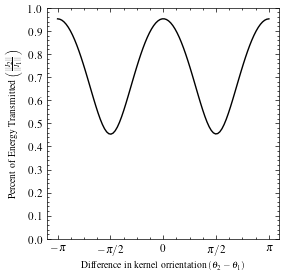

In [87]:
fig, ax= plt.subplots(1,1, figsize=(3,3))

ax.plot(angles,response_mag)

ticks = np.arange(-np.pi, 1.5*np.pi, np.pi/2)
labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels);
ax.set_yticks(ticks=np.arange(0,1.1, 0.1));

ax.set_ylabel(r"Percent of Energy Transmitted $\left( \frac{||I_{2}||}{||I_{1}||} \right)$", fontsize=7)
ax.set_xlabel(r"Difference in kernel orrientation $(\theta_2 - \theta_1)$", fontsize=7)

plt.savefig('malus2.pdf', dpi=600)
plt.show()


In [88]:
tf.reduce_sum(tf.abs(w))

<tf.Tensor: shape=(), dtype=float64, numpy=2.4494897427831788>

<tf.Tensor: shape=(), dtype=float32, numpy=500.22025>

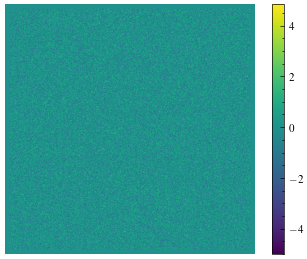

In [89]:
i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

fig, ax= plt.subplots(1,1)


im =ax.imshow(i0[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i0.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)

tf.math.reduce_euclidean_norm(i0)

In [90]:
np.sqrt(2/9)

0.4714045207910317

In [91]:
angle = 0

w = np.zeros((3,3,1,1))

w[:,:,0,0] = (np.cos(angle))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angle))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0,0] = ( w[:,:,0,0] )  / (tf.math.reduce_euclidean_norm(w))  
print(np.std(w))

i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 


i1 = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							 padding='SAME') )

fig, ax= plt.subplots(1,1)

im =ax.imshow(i1[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i1.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
#plt.title("Conv 1")


tf.math.reduce_euclidean_norm(i1)



0.33333333333333337


InvalidArgumentError: {{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} input must be 4-dimensional[520,520] [Op:Conv2D]

In [ ]:
3*np.std(w), tf.math.reduce_euclidean_norm(w)

(1.0, <tf.Tensor: shape=(), dtype=float64, numpy=1.0>)

KeyboardInterrupt: 

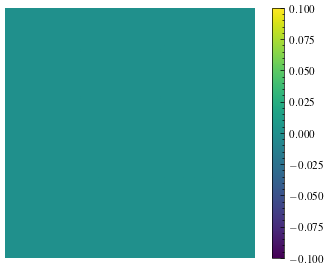

In [ ]:
angle = np.pi/2

w = np.zeros((3,3,1,1))
w[:,:,0,0] = (np.cos(angle))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angle))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0,0] = ( w[:,:,0,0] )  / (tf.math.reduce_euclidean_norm(w))  



i2_op = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2_op[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i1_y.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
#plt.title("Conv 2")

tf.math.reduce_euclidean_norm(i2_op)


<tf.Tensor: shape=(), dtype=float32, numpy=10.644074>

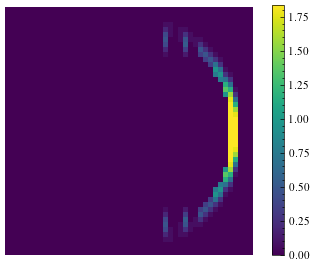

In [ ]:
angle = 0
w = np.zeros((3,3,1,1))
w[:,:,0,0] = (np.cos(angle))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angle))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0,0] = ( w[:,:,0,0] )  / (tf.math.reduce_euclidean_norm(w))  



i2_same = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2_same[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i1_x.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)


tf.math.reduce_euclidean_norm(i2_same)


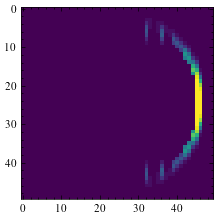

In [ ]:
plt.imshow((i2_same - i)[0, ..., 0])

Original shape: (3, 3, 10000)


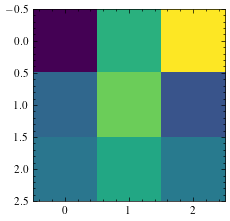

In [ ]:
img = np.random.normal(loc=0.0, scale=1.0, size=(3, 3, 10000))
print("Original shape:", img.shape)

# Pad with 10 pixels of zeros on all sides
#img = np.pad(img, pad_width=((10, 10), (10, 10)), mode='constant', constant_values=0)
fig, ax= plt.subplots(1,1)

im =ax.imshow(img[:,:,0])



In [ ]:
w = np.zeros((3,3,1))

w[:,:,0] = (np.cos(angle))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angle))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0] = ( w[:,:,0] )  / (tf.math.reduce_euclidean_norm(w))  
print(np.std(w))

0.33333333333333337


In [ ]:
tf.reduce_mean(tf.math.reduce_euclidean_norm(img, axis=(0,1)))


<tf.Tensor: shape=(), dtype=float64, numpy=2.9128320250300073>

In [ ]:
tf.reduce_mean(tf.math.reduce_sum(img*w, axis=(0,1)))

<tf.Tensor: shape=(), dtype=float64, numpy=-0.002084062299612617>

In [ ]:
tf.reduce_mean(tf.sqrt(np.random.normal(loc=0.0, scale=1.0, size=(3, 3, 10000))**2))

<tf.Tensor: shape=(), dtype=float64, numpy=0.7971891587012185>

In [ ]:


tf.reduce_mean(tf.nn.relu(tf.reduce_sum(img*w, axis=(0,1))))

<tf.Tensor: shape=(), dtype=float64, numpy=0.39592018855464745>

In [ ]:
s, a = getSymAntiSymTF(tf.expand_dims(img, axis=-1))
tf.reduce_mean(tf.math.reduce_euclidean_norm(a,axis=(0,1)))

(1, 3, 3, 10000) (1, 3, 3, 10000) (1, 3, 3, 10000)


<tf.Tensor: shape=(), dtype=float64, numpy=2.344168313327407>

In [ ]:
w = np.zeros((3,3,1))

w[:,:,0] = (np.cos(angle))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angle))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0] = ( w[:,:,0] )  / (tf.math.reduce_euclidean_norm(w))  
print(np.std(w))

print(tf.math.reduce_mean(img))

i1 = tf.nn.relu( tf.nn.conv2d(i0, w , strides=(1,1), 
							 padding='SAME') )
print(tf.math.reduce_euclidean_norm(i1))

fig, ax= plt.subplots(1,1)

im =ax.imshow(i1[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');

0.33333333333333337
tf.Tensor(-0.011338168030311676, shape=(), dtype=float64)


InvalidArgumentError: {{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} filter must be 4-dimensional: [3,3,1] [Op:Conv2D]